# **Car Detection Menggunakan YOLOv5**

## Prequisite

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%pip install numpy pandas opencv-python torch tqdm matplotlib kaggle
%pip install -r yolov5/requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.


## Import Library

In [ ]:
import os
import re
import random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Cek Apakah Terdapat GPU yang dapat digunakan, jika tidak maka menggunakan CPU
if torch.cuda.is_available():
    device = '--device 0'
else:
    device = ''

## Baca Dataset

In [ ]:
# Download dataset dan unzip file
!kaggle datasets download -d sshikamaru/car-object-detection
sh.unpack_archive("car-object-detection.zip")

Dataset URL: https://www.kaggle.com/datasets/sshikamaru/car-object-detection
License(s): other
 87% 97.0M/112M [00:00<00:00, 161MB/s]
100% 112M/112M [00:00<00:00, 154MB/s] 


In [ ]:
df = pd.read_csv('data/train_solution_bounding_boxes (1).csv')

In [ ]:
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


## Preprocess Data

### Menyesuaikan Data Berdasarkan Aturan YOLOv5

In [ ]:
# Informasi Ukuran Gambar
img_width, img_height = (676, 380)

# Menyiapkan Kolom yang Dibutuhkan Berdasarkan aturan YOLOv5
df['image'] = df['image'].apply(lambda x: x.split('.')[0])
df['class'] = 0
df['x_center'] = ((df['xmin'] + df['xmax'])/2)/img_width
df['y_center'] = ((df['ymin'] + df['ymax'])/2)/img_height
df['width'] = (df['xmax'] - df['xmin'])/img_width
df['height'] = (df['ymax'] - df['ymin'])/img_height

In [ ]:
df.head()

,image,xmin,ymin,xmax,ymax,class,x_center,y_center,width,height
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0,0.450434,0.539817,0.068741,0.095238
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0,0.100217,0.557191,0.155572,0.129987
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0,0.444645,0.543678,0.181621,0.157014
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0,0.833213,0.531451,0.197540,0.155727
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0,0.110347,0.559122,0.171491,0.136422


### Memisahkan Gambar Training dan Value dari Gambar berdasarkan file CSV

In [ ]:
source_img = 'data/training_images'
dest_train = 'data/train_data'

if not os.path.exists(dest_train):
    os.mkdir(dest_train)

for data in df.values:
    # Buat file yang akan berisi value dari tiap gambar
    filename = '{}/{}.txt'.format(dest_train, data[0])

    # Kolom yang akan disimpan dalam file
    data_object = data[5:]

    # Copy gambar train yang memiliki gambar mobil ke folder baru
    source_img_file = os.path.join(source_img, '{}.jpg'.format(data[0]))
    destination_img_file = os.path.join(dest_train, '{}.jpg'.format(data[0]))
    sh.copy(source_img_file, destination_img_file)

    # Mengisi file dengan nilai dari masing-masing gambar yang berada di csv
    if os.path.exists(filename):
        with open(filename, 'a') as file:
            file.write('\n')
            file.write(' '.join(map(str, list(data_object))))
    else:
        data_object.tofile(filename, sep=" ", format="%s")

### Membuat Informasi Data untuk Pelatihan Model

In [ ]:
# Membuat informasi mengenai data yang akan digunakan untuk pelatihan
with open('yolov5/dataset.yaml', 'w+') as f:
    f.write('path: ../data\n')
    f.write('train: train_data\n')
    f.write('val: train_data\n\n')
    f.write('names:\n')
    f.write('  0: car')

## Training Model

In [ ]:
cd yolov5

/content/yolov5


### Training

In [ ]:
# Train model
!python train.py --img 676 --epochs 5 --data dataset.yaml --weights yolov5m.pt {device} 2>&1 | tee trained_path.txt

2024-05-17 14:03:52.105805: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 14:03:52.105857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 14:03:52.107328: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5m.pt, cfg=, data=dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=16, imgsz=676, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, op

In [ ]:
# Baca file output
with open('trained_path.txt', 'r') as f:
    trained_path = f.read()
match = re.search(r"Results saved to (.+)", trained_path)

# Simpan direktori model train
trained_path = match.group(1)
trained_path = re.sub(r"\033\[\d+m", "", trained_path)

### Performa Model

(-0.5, 2249.5, 1499.5, -0.5)

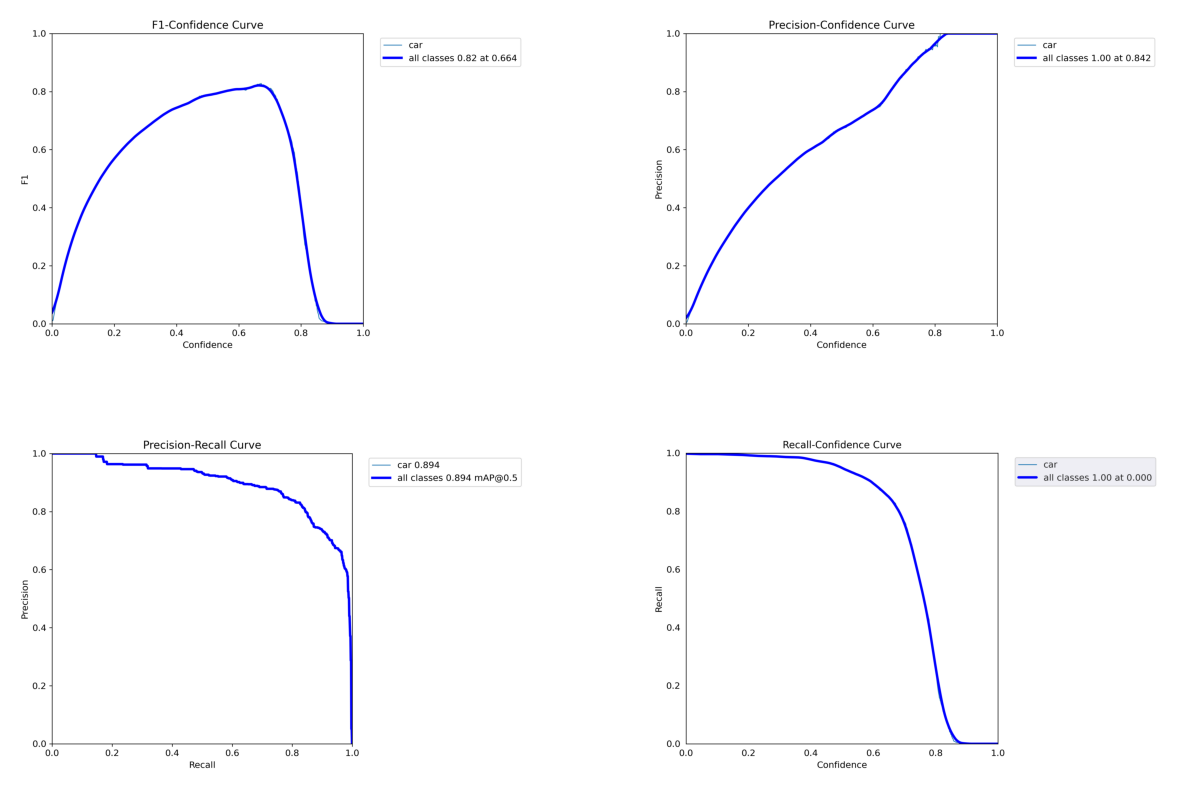

In [ ]:
# Load gambar
f1 = cv2.imread('{}/F1_curve.png'.format(trained_path))
p = cv2.imread('{}/P_curve.png'.format(trained_path))
pr = cv2.imread('{}/PR_curve.png'.format(trained_path))
r = cv2.imread('{}/R_curve.png'.format(trained_path))

# Convert gambar dari BGR to RGB (OpenCV load gambar dalam BGR format)
f1 = cv2.cvtColor(f1, cv2.COLOR_BGR2RGB)
p = cv2.cvtColor(p, cv2.COLOR_BGR2RGB)
pr = cv2.cvtColor(pr, cv2.COLOR_BGR2RGB)
r = cv2.cvtColor(r, cv2.COLOR_BGR2RGB)

# Buat plot dengan 2 baris dan 2 kolom
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Tampil gambar
axs[0, 0].imshow(f1)
axs[0, 0].axis('off')
axs[0, 1].imshow(p)
axs[0, 1].axis('off')
axs[1, 0].imshow(pr)
axs[1, 0].axis('off')
axs[1, 1].imshow(r)
axs[1, 1].axis('off')

## Predict Gambar

### Menggunakan PyTorch Hub

In [ ]:
# Inferensi menggunakan pytorch hub
model = torch.hub.load('ultralytics/yolov5', 'custom', path='{}/weights/best.pt'.format(trained_path))

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-5-17 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


In [ ]:
# Prediksi Data
img = '../data/testing_images/vid_5_29820.jpg'
results = model(img)
results.print()

image 1/1: 380x676 1 car
Speed: 8.9ms pre-process, 80.8ms inference, 550.6ms NMS per image at shape (1, 3, 384, 640)


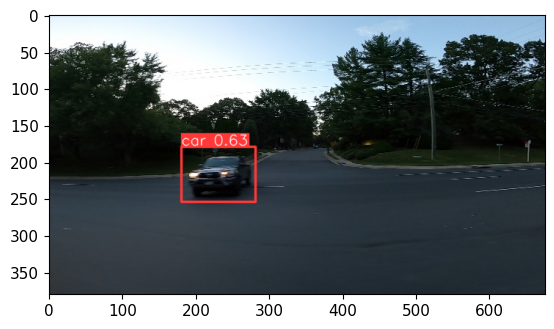

In [ ]:
# Menampilkan Hasil Prediksi
%matplotlib inline
plt.imshow(np.squeeze(results.render()))
plt.show()

### Menggunakan Detect.py

In [ ]:
# Inferensi Menggunakan detect.py
!python detect.py --weights {trained_path}/weights/best.pt --source ../data/testing_images {device} 2>&1 | tee detected_path.txt

detect: weights=['runs/train/exp/weights/best.pt'], source=../data/testing_images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-312-g1bcd17ee Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
image 1/175 /content/data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 51.9ms
image 2/175 /content/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 19.8ms
image 3/175 /content/data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 19.7ms
image 4/175 /content/data/testing_images/vid_5_25160.j

In [ ]:
# Baca file output
with open('detected_path.txt', 'r') as f:
    detected_path = f.read()
match = re.search(r"Results saved to (.+)", detected_path)

# Simpan direktori model train
detected_path = match.group(1)
detected_path = re.sub(r"\033\[\d+m", "", detected_path)

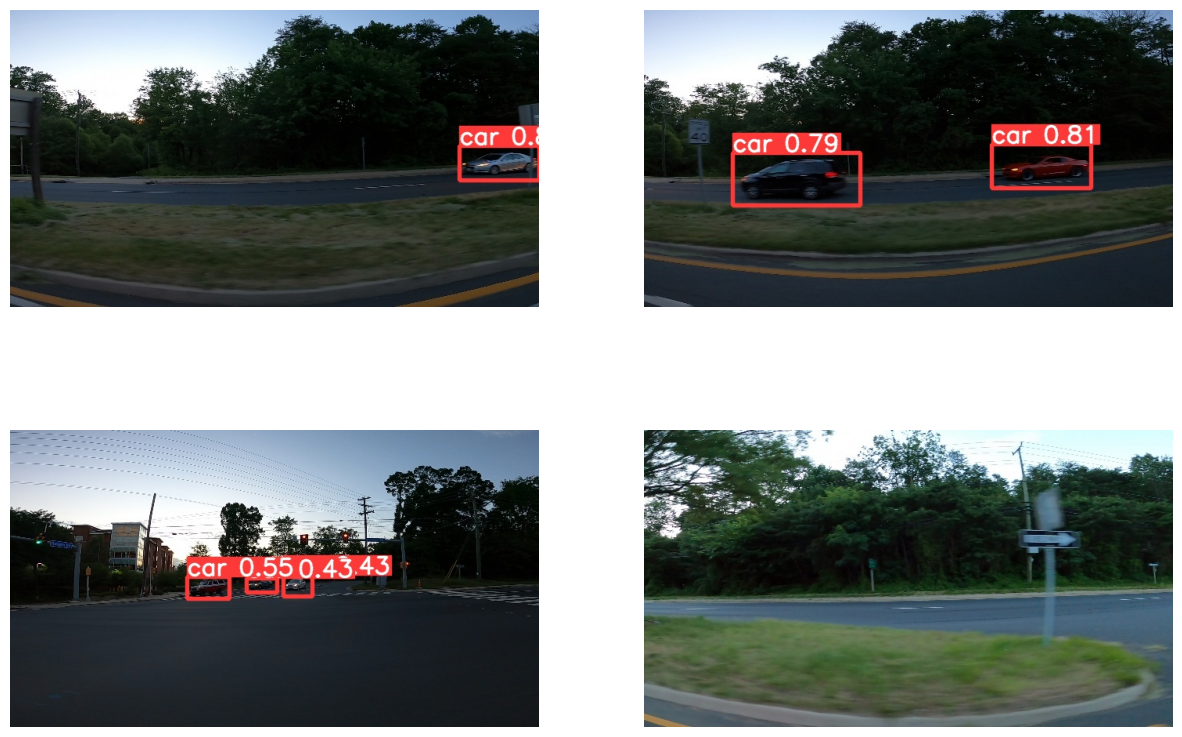

In [ ]:
image = os.listdir(detected_path)

# ambil 4 gambar random untuk hasil prediksi
selected_images = random.sample(image, 4)

# load dan convert image
images = []
for image_file in selected_images:
    image_path = os.path.join(detected_path, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

# Membuat plot dengan baris 2 dan kolom 2
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Menampilkan gambar
for ax, image in zip(axs.flat, images):
    ax.imshow(image)
    ax.axis('off')

plt.show()